# Competitive Pokemon: A data-centric analysis on what makes a Pokemon viable.
By Jeremy Jubilee

![Pokemon Logo](img/pokemon_logo.png "Pokemon is Fun!!!")
## Table of Contents

1. [Introduction](#intro)
    1. [Smogon: What is Competitive Pokemon?](#intro_smogon)
    2. [Background Information](#intro_info)
2. [Data Collection](#collect)
    1. [APIs](#collect_api)
    2. [HTML](#collect_html)
3. Data Cleaning
4. Exploratory Data Analysis
    1. Usage Tiers
    2. Typing
5. Classification
6. Insight

<a id='intro'></a>
# Part 1: Introduction

Since 1996, Pokemon has been touching the hearts of millions, selling over 240 million copies of the main franchise alone. Cute mascots combined with simple, rewarding gameplay loops provide an enjoyable experience for every type of player. Surprisingly, these cute pokemon hide a deep, mathematical world underneath them. The mechanics of pokemon have always been complex, but abstracted enough such that they don’t hold too much of a bearing for casual players. However, for the hardcore, optimization of Pokemon gameplay is a rich experience.

With this project, my goal is to determine what makes a Pokemon competitively viable. I will scrape information about Pokemon and process it to figure out how to judge the strength of a Pokemon! Along the way, I will answer some popular questions about the competitive Pokemon scene, such as the importance of certain moves, the strength of newer vs. older pokemon, and the impact of the base properties of Pokemon!

---

<a id='intro_smogon'></a>
What is Competitive Pokemon?
---
###### If you know a decent amount about Pokemon, you can skip this section and hop right into the [data collection!](#data_collection_raw)
In [competitive Pokemon](https://www.smogon.com/dp/articles/intro_comp_pokemon#tiers), players build a team of 6 pokemon and have them battle each other. In single battles, Pokemon come out one at a time, and in double battles, they come out two at a time. Pokemon use moves to damage the enemy pokemon until their health goes to zero, at which point they faint. When all your Pokemon faint, you lose. 

So, as a competitive player, how do you choose the best 6 pokemon to build your ideal team? First, let's talk about what a pokemon is in terms of data that is important to a competitive player. Every Pokemon has 6 stats, types, moves, and abilities. These are what discern Pokemon from eachother in a competitive sense.

---

<a id='intro_info'></a>
A bit of background information about Pokemon
---
**[The 6 stats](https://bulbapedia.bulbagarden.net/wiki/Statistic) are as follows:**
- *Health Points (HP):* Health Points indicate the amount of damage a pokemon can take before dying. 
- *Attack (Atk):* Attack is related to damage for physical type moves. More attack is more damage dealt.
- *Defense (Def):* Defense is related to damage recieved for physical type moves. More defense is less damage taken.
- *Special Attack (SpA):* Special Attack is like attack, but for special type moves.
- *Special Defense (SpD):* Special Defense is like defense, but for special type moves.
- *Speed (Spe):* Speed determines the move order of pokemon. Pokemon with a higher speed stat go first. 
---
**[Types](https://bulbapedia.bulbagarden.net/wiki/Type) are properties of Pokemon and their moves.** 

*The Pokemon Typing* of a Pokemon determine the damage they take from certain moves and effects, and also play a part in the [damage calculation](https://bulbapedia.bulbagarden.net/wiki/Damage) of certain moves. For instance, if a Pokemon is a fire-type, they will recieve more damage from water-type moves, and less damage from grass-type moves. Additionally, if that Pokemon were to use a fire-type move, they would deal more damage. Pokemon can have one or two types.

All Pokemon have a set of [moves that they can learn](https://bulbapedia.bulbagarden.net/wiki/Move). Moves have *Move Typing*, and can either be physical, special, or status-inducing. ["Coverage"](https://pokemondb.net/tools/type-coverage) is the ability for an individual Pokemon or a team of Pokemon to give and take damage across a variety of types is called, and is a great indicator of how flexible a pokemon can be on the battlefield. A Pokemon can only bring 4 moves into battle at a time, meaning that we have to choose from our pool carefully.

---
**[Abilities](https://bulbapedia.bulbagarden.net/wiki/Ability) are unique points about Pokemon that can effect the tides of battle!**

All Pokemon have a set of abilities which have a unique effect. These can range from immunity to certain moves, creating certain weather or terrain conditions, or boosting the effects of certain moves. Pokemon have anywhere from 1 to 3 abilities to choose from, and can only have one in effect at a time. 

---

<a id='collect'></a>
# Part 2: Data Collection, Scraping from APIs and HTML

The first part of the data pipeline is collection. We're going to start out with importing stuff that we use to collect the data. The documentation for the libraries we use is linked in the descriptions!

- [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a Python library used to scrape from webpages. It has great HTML and LXML parsers to help you get all the raw text that you need.
- `re` is Python's regular expression library. Regular expressions are powerful tools used to quickly match substrings.
- [`requests`](https://requests.readthedocs.io/en/master/) is an HTTP library that makes it easier to send requests to sites.
- [`json`](https://www.w3schools.com/js/js_json_intro.asp), **J**ava**S**cript **O**bject **N**otation, is a syntax used to communicate data. A lot of the data stored online and from APIs comes to us in this form, and this plugin allows us to parse it much easier.
- [`numpy`](https://docs.scipy.org/doc/numpy/user/whatisnumpy.html) is a package for scientific computation on arrays. This is fundamental to our next package...
- [`pandas`](https://pandas.pydata.org/pandas-docs/stable/) is a powerful data analysis toolkit for python. Perhaps the most important package, this introduces the DataFrame object, a fantastic tool for data storage and ease of analysis.
- `time` and `clear_output` are going to be used to make sure we don't overload websites with requests. More on this later.

With all that out of the way, let's import!

In [1]:
from bs4 import BeautifulSoup as bs
import re
import requests
import json
import pandas as pd
import time
import numpy as np
from IPython.display import clear_output

# This is a flag that you should tick true if this is your first time running this. 
NEW_CSV_FLAG = False
# This flag is for debug output.
DEBUG_FLAG = True

<a id='collect_api'></a>
Requesting Data From an API
---
![PokeAPI](img/pokeapi_logo.png "This is an incredibly helpful resource~")

The API we're scraping from for this project is [PokeAPI](https://pokeapi.co/). Now, before starting any code for scraping from an API, we should note a few things. Firstly, we should take a look at the [documentation](https://pokeapi.co/docs/v2.html/#info) for the API. This lets us know what we should request from the API, and the information it can provide, along with the format. We see that all we do is send requests with the requests plugin, and recieve our information back in JSON format.

One thing to note is that because the API is free-use and does not require any authentication, we have to be careful with how many requests we send. PokeAPI asks us to limit ourselves to **100 REQUESTS PER MINUTE**, and we should respect that, which explains why I imported the time library.

However, waiting for all the stuff to download is a tall task to ask. So, I've exported the data as a CSV that you can [download here]. IF you want to try downloading it all yourself, just remember to change the flag in that first block of code. Let's start with a simple example.

In [2]:
pokes_by_gen = []
for i in range(1, 8):
    url = 'https://pokeapi.co/api/v2/generation/' + str(i)
    response = requests.get(url)
    cur_gen = response.json() if response and response.status_code == 200 else None
    poke_list = []
    for j in range (0, len(cur_gen['pokemon_species'])):
        poke_list.append(cur_gen['pokemon_species'][j]['name'])
    pokes_by_gen.append(poke_list)    
    
def find_gen(name):
    for i in range(0, len(pokes_by_gen)):
        if name in pokes_by_gen[i]:
            return i+1
    return np.nan

---
**This block of code forms the request URL of the current pokemon.** A response code of 200 indicates that we successfully recieved the data back from the API. the `.json()` method converts the response to a JSON load, which allows us to index the elements with ease!
```python
url = 'https://pokeapi.co/api/v2/generation/' + str(i)
response = requests.get(url)
cur_gen = response.json() if response and response.status_code == 200 else None
```

We basically iterate through all 7 of the generations, then iterate through the list of pokemon that were introduced in that generation! `find_gen()` is a function we write to help us find the generation of a pokemon based on its name!

Now, let's get into the meat of the scraping. 

In [3]:
# Check the flag to see if we will scrape it raw!
if NEW_CSV_FLAG:
    pokemon_cols = ['dex_id', 'name', 'spe', 'spd', 'spa', 'dfn', 'atk', 'hp', 
                    'type_1', 'type_2', 'move_list', 'gen']
    df_pokemon = pd.DataFrame(columns = pokemon_cols)
    
    # This is the amount of pokemon that are in generation 7!
    for i in range(1, 808):
        
        # Make sure we don't overload the pokeAPI with requests!
        time.sleep(0.6)
        
        url = 'https://pokeapi.co/api/v2/pokemon/' + str(i)
        response = requests.get(url)
        cur_data = response.json() if response and response.status_code == 200 else None
        # Something went wrong?
        if cur_data == None:
            continue
        
        # ------------------------------------------------------------------------------------
        # This section is about getting the information that we want! See below for more info.
        dex_id = cur_data['id']
        name = cur_data['name']
        gen = find_gen(name)
        spe = cur_data['stats'][0]['base_stat']
        spd = cur_data['stats'][1]['base_stat']
        spa = cur_data['stats'][2]['base_stat']
        dfn = cur_data['stats'][3]['base_stat']
        atk = cur_data['stats'][4]['base_stat']
        hp  = cur_data['stats'][5]['base_stat']
        
        # Check if current pokemon is monotype or dual-typed
        type_1 = cur_data['types'][0]['type']['name']
        if (len(cur_data['types']) == 2):
            type_2 = cur_data['types'][1]['type']['name']
        else:
            type_2 = np.nan

        # Get the moves that the pokemon can potentially learn!
        move_list = []
        for j in range(0, len(cur_data['moves'])):
            move_list.append(cur_data['moves'][j]['move']['name'])
        # ------------------------------------------------------------------------------------
        
        new_pokemon = pd.Series([dex_id, name, spe, spd, spa, dfn, atk, hp, type_1, type_2, move_list, gen], index = pokemon_cols)
        df_pokemon = df_pokemon.append(new_pokemon, ignore_index = True)
    
        # Debug output if making your own CSV
        if DEBUG_FLAG:
            clear_output()
            print('Processing Pokedex Entry Number: ' + str(dex_id) + '; Name: ' + name)
            
    df_pokemon.to_csv('pokemon_list.csv')
else:
    
    # Don't request from the API, read my CSV
    df_pokemon = pd.read_csv('pokemon_list.csv')
    # This line cleans up the formatting of the read_csv() method to match our OG dataframe.
    df_pokemon = df_pokemon.loc[:, ~df_pokemon.columns.str.contains('^Unnamed')]
    
# Print the first few elements to see if our formatting is correct!
df_pokemon.head(5)

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,move_list,gen
0,1,bulbasaur,45,65,65,49,49,45,poison,grass,"['razor-wind', 'swords-dance', 'cut', 'bind', ...",1.0
1,2,ivysaur,60,80,80,63,62,60,poison,grass,"['swords-dance', 'cut', 'bind', 'vine-whip', '...",1.0
2,3,venusaur,80,100,100,83,82,80,poison,grass,"['swords-dance', 'cut', 'bind', 'vine-whip', '...",1.0
3,4,charmander,65,50,60,43,52,39,fire,NaN,"['mega-punch', 'fire-punch', 'thunder-punch', ...",1.0
4,5,charmeleon,80,65,80,58,64,58,fire,NaN,"['mega-punch', 'fire-punch', 'thunder-punch', ...",1.0


### That may have been a lot to process mentally. Let's take a look at the most important lines of code to see what they do.

---
**This block of code makes us an empty dataframe with the labels that we need.** A dataframe is the main basis of pandas, and allows us to store data in a way that is quick to manipulate and calculate with.
```python
pokemon_cols = ['dex_id', 'name', 'spe', 'spd', 'spa', 'dfn', 'atk', 'hp', 
                'type_1', 'type_2', 'move_list', 'gen]
df_pokemon = pd.DataFrame(columns = pokemon_cols)
```
---
**That entire block about getting the information creates and assigns some temporary variables that correspond to the entries that we're going to put into our dataframe.** 

The big question you may have is: *How do you know what indeces to access to get the right information?* 

To do this, we can use a [JSON viewer](http://jsonviewer.stack.hu/) to see the way that the data is formatted. I also used the PokeAPI documentation to help me out. This can very much be a trial and error process, but once you get the notation of the data down, JSON becomes a fast and powerful tool in your arsenal.

---
**This block of code forms a Pandas Series, a row in our dataframe which holds the information.** Then we just add it to the dataframe right at the end! Since we iterate through the Pokemon in numerical order anyway, this actually keeps it in order for us! (not that it matters though...)
```python
new_pokemon = pd.Series([dex_id, name, spe, spd, spa, dfn, atk, hp, 
                         type_1, type_2, move_list], index = pokemon_cols)
df_pokemon = df_pokemon.append(new_pokemon, ignore_index = True)
```
---

Finally, the `to_csv()` and `read_csv()` methods from Pandas convert dataframes to [CSV files](https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/), which are plain-text files that hold lots o' data!


<a id='collect_html'></a>
Scraping Data From an HTML Page
---
We're going to be scraping from three different sites. 
- [PokemonDB](https://pokemondb.net/) is a community site that aims to make information about Pokemon clear and available. 
- [Bulbapedia](https://bulbapedia.bulbagarden.net/) is a community wiki with a ton of information about everything Pokemon!44
- [Smogon's StrategyDex](https://www.smogon.com/dex/) is a site holding the competitive information of pokemon in a generation. Since we're working with generation 7, we'll use the Sun/Moon pages.

Lets start with the easier of the three to work with.
![Pokemondb](img/pokemondb_logo.png "This is an incredibly helpful resource~")
![Bulbapedia](img/bulbapedia_logos.png "This is an incredibly helpful resource~")

We're going to get the information about all the moves, all the abilities, and all the items in Pokemon. These are respectively stored on seperate pages on PokemonDB. The information is stored in tables directly coded into the HTML format, which makes it significantly easier to parse. Let's make a dataframe for each of these pages!

#### Moves

In [4]:
if NEW_CSV_FLAG:
    response = requests.get('http://pokemondb.net/move/all')
    soup = bs(response.text, 'html.parser')
    tab = soup.find("table")
    tab_rows = tab.find_all('tr')
    move_cols = ['name', 'type', 'category', 'power', 'acc', 'pp', 'tm', 'effect', 'chance']
    df_moves = pd.DataFrame(columns = move_cols)
    for i in range(1, len(tab_rows)):
        tab_entries = tab_rows[i].find_all('td')
        
        # We do this to match the format of the moves 
        row = [t.text for t in tab_entries]
        # Get the value we need, telling us category of move
        row[2] = tab_entries[2]['data-sort-value']
        new_move = pd.Series(row, index = move_cols)
        df_moves = df_moves.append(new_move, ignore_index = True)
    df_moves.to_csv('moves_list.csv')
else:
    
    # Don't scrape from HTML
    df_moves = pd.read_csv('moves_list.csv')
    df_moves = df_moves.loc[:, ~df_moves.columns.str.contains('^Unnamed')]

df_moves.head(5)

,name,type,category,power,acc,pp,tm,effect,chance
0,"10,000,000 Volt Thunderbolt",Electric,special,195,—,1,NaN,Pikachu-exclusive Z-Move.,NaN
1,Absorb,Grass,special,20,100,25,NaN,User recovers half the HP inflicted on opponent.,—
2,Accelerock,Rock,physical,40,100,20,NaN,User attacks first.,NaN
3,Acid,Poison,special,40,100,30,NaN,May lower opponent's Special Defense.,10
4,Acid Armor,Poison,status,—,—,20,NaN,Sharply raises user's Defense.,—


#### Abilities

In [5]:
if NEW_CSV_FLAG:
    response = requests.get('https://pokemondb.net/ability')
    soup = bs(response.text, 'html.parser')
    tab = soup.find("tbody")
    tab_rows = tab.find_all('tr')
    abil_cols = ['name', 'pokemon_count', 'description', 'generation']
    df_abils = pd.DataFrame(columns = abil_cols)
    for i in range(1, len(tab_rows)):
        tab_entries = tab_rows[i].find_all('td')
        # We do this to match the format of the abilities 
        row = [t.text for t in tab_entries]
        new_abil = pd.Series(row, index = abil_cols)
        df_abils = df_abils.append(new_abil, ignore_index = True)
    df_abils.to_csv('abils_list.csv')
else:
    
    # Don't scrape from HTML
    df_abils = pd.read_csv('abils_list.csv')
    df_abils = df_abils.loc[:, ~df_abils.columns.str.contains('^Unnamed')]

df_abils.head(5)

,name,pokemon_count,description,generation
0,Aerilate,2,Turns Normal-type moves into Flying-type moves.,6
1,Aftermath,8,Damages the attacker landing the finishing hit.,4
2,Air Lock,1,Eliminates the effects of weather.,3
3,Analytic,12,Boosts move power when the Pokémon moves last.,5
4,Anger Point,9,Maxes Attack after taking a critical hit.,4


#### Items

In [6]:
if NEW_CSV_FLAG:
    response = requests.get('https://pokemondb.net/item/all')
    soup = bs(response.text, 'html.parser')
    tab = soup.find("tbody")
    tab_rows = tab.find_all('tr')
    item_cols = ['name', 'category', 'effect']
    df_items = pd.DataFrame(columns = item_cols)
    for i in range(1, len(tab_rows)):
        tab_entries = tab_rows[i].find_all('td')
        # We do this to match the format of the abilities 
        row = [t.text for t in tab_entries]
        new_item = pd.Series(row, index = item_cols)
        df_items = df_items.append(new_item, ignore_index = True)
    df_items.to_csv('items_list.csv')
else:
    
    # Don't scrape from HTML
    df_items = pd.read_csv('items_list.csv')
    df_items = df_items.loc[:, ~df_items.columns.str.contains('^Unnamed')]

df_items.head(5)

,name,category,effect
0,\r\n Ability Urge\r\n,Battle items,"When used, it activates the Ability of an ally..."
1,\r\n Abomasite\r\n,Hold items,Enables Abomasnow to Mega Evolve during battle.
2,\r\n Absolite\r\n,Hold items,Enables Absol to Mega Evolve during battle.
3,\r\n Absorb Bulb\r\n,Hold items,A consumable bulb. If the holder is hit by a W...
4,\r\n Adamant Mint\r\n,Battle items,Changes the Pokémon's stats to match the Adama...


#### Natures (From Bulbapedia)

In [7]:
if NEW_CSV_FLAG:
    response = requests.get('https://bulbapedia.bulbagarden.net/wiki/Nature')
    soup = bs(response.text, 'html.parser')
    tab = soup.find("table", {'class':"roundy sortable"})
    tab_rows = tab.findAll('tr')
    item_cols = ['number', 'japanese', 'increased_stat','decreased_stat',
                'favorite_flavor','disliked_flavor','nature']
    df_natures = pd.DataFrame(columns = item_cols)
    for i in range(1, len(tab_rows) -1):
        tab_entries = tab_rows[i].find_all('td')
        # We do this to match the format of the abilities 
        row = [t.text for t in tab_entries]
        row.append(tab_rows[i].find('th').text)
        new_item = pd.Series(row, index = item_cols)
        df_natures = df_natures.append(new_item, ignore_index = True)
    df_natures.to_csv('natures.csv')    
else:
    # Don't scrape from HTML
    df_natures = pd.read_csv('natures.csv')
    df_natures = df_natures.loc[:, ~df_natures.columns.str.contains('^Unnamed')]

df_natures.head(5)

,number,japanese,increased_stat,decreased_stat,favorite_flavor,disliked_flavor,nature
0,0,がんばりや\r\n,—\r\n,—\r\n,—\r\n,—\r\n,Hardy\r\n
1,1,さみしがり\r\n,Attack\r\n,Defense\r\n,Spicy\r\n,Sour\r\n,Lonely\r\n
2,2,ゆうかん\r\n,Attack\r\n,Speed\r\n,Spicy\r\n,Sweet\r\n,Brave\r\n
3,3,いじっぱり\r\n,Attack\r\n,Sp. Attack\r\n,Spicy\r\n,Dry\r\n,Adamant\r\n
4,4,やんちゃ\r\n,Attack\r\n,Sp. Defense\r\n,Spicy\r\n,Bitter\r\n,Naughty\r\n


Lets take a look at some of the new methods that were introduced to us here.

- `bs` takes two parameters and initializes BeautifulSoup. The first parameter is the text of what we want to parse. The second parameter is the type of parser we will use, in this case, the HTML parser.
- `find()` and `find_all()` are BeautifulSoup methods that find the HTML tags and return their contents. 
- `tbody`,`tr`, and `td` are all HTML tag types that involve the HTML table. They hold the stuff that we extract with the aforementioned methods.
---

Now let's work on the fussy one...
![Smogon University](img/smogon_uni_logo.png "yikes~")

This site holds the competitive-relevant information of Pokemon. We want to know the following:
- The format/tier that the Pokemon is categorized in
- Whether or not it's a fully evolved Pokemon
- The abilities it can have
- The *competitive ideals* of the following for the Pokemon:
    - Moveset
    - Ability
    - Held Item
    - Nature

---
The site has a list of all the Pokemon in the generation, but it's not in the same format as the PokeAPI. This is where things get rough. Unlike PokeAPI, Smogon's Dex lists alternate forms of Pokemon as individual entries.

![entries](img/smogon_entry_forms.png)

This is a fairly easy problem to deal with, as we can just clean up the alternative forms later and collect the data anyway. However, there's a much bigger issue at hand. Smogon's Dex only lists **competitive-relevant** information about Pokemon. This means that if a Pokemon isn't relevant to the scene, it just wont have any information on that Pokemon's page. Take a look.

| [Aegislash](https://www.smogon.com/dex/sm/pokemon/aegislash/): Competitive-relevant | [Aipom](https://www.smogon.com/dex/sm/pokemon/aipom/): Non-Relevant|
| :---: | :---: |
|<img src="img/smogon_entry_success.png" width="333">  |  <img src="img/smogon_entry_failure.png" width="333">|

This means that if the Pokemon or any of its forms aren't competitively relevant, the *competitive ideals* will be completely missing! To account for this, we'll simply put all the competitive fields in as `np.nan` if the page is missing, indicating the missingness of the relevant information!

In [8]:
if NEW_CSV_FLAG:
    smog_cols = ['name', 'smogon_format', 'is_final_evo', 'abilities', 'moveset',
                 'ideal_ability', 'ideal_item', 'ideal_nature']   
    response = requests.get('http://smogon.com/dex/sm/pokemon')
    soup = bs(response.text, 'html.parser')
    script_string = soup.find('script').string
    script_string = script_string.strip()
    script_string = script_string.replace('dexSettings = ', '')
    load = json.loads(script_string)
    poke_load = load['injectRpcs'][1][1]
    smogon_pokemon = poke_load['pokemon']
    df_smogon = pd.DataFrame(columns = smog_cols)
    for cur_poke in smogon_pokemon:
        try:
            
            # Make sure we don't overload Smogon's Dex with requests!
            time.sleep(0.6)
            
            name = cur_poke['name']
            smogon_format = np.nan
            is_final_evo = True
            response = requests.get('http://smogon.com/dex/sm/pokemon/' + name)
            soup = bs(response.text, 'html.parser')
            script_string = soup.find('script').string
            script_string = script_string.strip()
            script_string = script_string.replace('dexSettings = ', '')
            load = json.loads(script_string)
            
            if DEBUG_FLAG:
                clear_output()
                print('Processing Smogon: ' + name)
            
            try:
                moves = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['moveslots']
                abil = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['abilities']
                item = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['items']
                nat = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['natures']
            except:
                moves = np.nan
                abil = np.nan
                item = np.nan
                nat = np.nan

            if (len(cur_poke['formats']) == 1):
                smogon_format = cur_poke['formats'][0]
            if (len(cur_poke['oob']['evos']) != 0):
                is_final_evo = False
            abils = cur_poke['abilities']
            entries = [name, smogon_format, is_final_evo, abils, moves, abil, item, nat]
            new_pokemon = pd.Series(entries, index = smog_cols)
            df_smogon = df_smogon.append(new_pokemon, ignore_index = True)
        except:
            ;
    df_smogon.to_csv('smogon_tiers.csv')
else:
    
    # Don't request from the API
    df_smogon = pd.read_csv('smogon_tiers.csv')
    df_smogon = df_smogon.loc[:, ~df_smogon.columns.str.contains('^Unnamed')]

df_smogon.head(5)

,name,smogon_format,is_final_evo,abilities,moveset,ideal_ability,ideal_item,ideal_nature
0,bulbasaur,LC,False,"['Chlorophyll', 'Overgrow']","[['Celebrate'], ['Sludge Bomb'], ['Giga Drain'...",['Chlorophyll'],['Normalium Z'],['Modest']
1,ivysaur,NaN,False,"['Chlorophyll', 'Overgrow']",NaN,NaN,NaN,NaN
2,venusaur,RU,True,"['Chlorophyll', 'Overgrow']","[['Growth'], ['Sludge Bomb'], ['Giga Drain'], ...",['Chlorophyll'],"['Life Orb', 'Grassium Z']",['Modest']
3,charmander,LC,False,"['Blaze', 'Solar Power']","[['Dragon Dance'], ['Flare Blitz'], ['Hidden P...",['Blaze'],['Life Orb'],['Adamant']
4,charmeleon,NaN,False,"['Blaze', 'Solar Power']",NaN,NaN,NaN,NaN


This code looks pretty different from our HTML scraping of PokemonDB. That's because there was a big issue with the parsing: *All the information is loaded onto a script that runs on the pages.*

To fix this, we just use the `find()` method to get the script contents, then clean it up with `strip()` and `replace()` to get something that can be converted into a JSON load with the `loads()` method. Now, like earlier with the PokeAPI's JSON, we have to *figure out what indeces to access to get the right information.* 

Again, we can use a [JSON viewer](http://jsonviewer.stack.hu/) to see the way that the data is formatted. Here, I additionally used json's `keys()` method to find the names of the indeces that we want to access, and also the `len()` method for lists. 

That's how we get the neater lines of code like this:
```python
moves = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['moveslots']
abil = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['abilities']
item = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['items']
nat = load['injectRpcs'][2][1]['strategies'][0]['movesets'][0]['natures']
```

Everything else is the same as before. Now, let's get the type weaknesses, which were also in the script string from Smogon!

In [9]:
if NEW_CSV_FLAG:
    
    ## Use load from earlier!
    move_load = poke_load['types']
    pokemon_types = ['attacking_type']
    for cur_type in move_load:
        pokemon_types.append(cur_type['name'])
    df_types = pd.DataFrame(columns = pokemon_types)
    for cur_type in move_load:
        new_type = pd.Series(pokemon_types, index = pokemon_types)
        new_type['attacking_type'] = cur_type['name']
        for t, v in cur_type['atk_effectives']:
            new_type[t] = v
        df_types = df_types.append(new_type, ignore_index = True)
    df_types.to_csv('type_effectiveness.csv')
else:
    
    # Don't request from the API
    df_types = pd.read_csv('type_effectiveness.csv')
    df_types = df_types.loc[:, ~df_types.columns.str.contains('^Unnamed')]
    pokemon_types = list(df_types.columns)
df_types

,attacking_type,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,Bug,1.0,2.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,2.0,1.0,1.0,1,0.5,2.0,1.0,0.5,1.0
1,Dark,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1,1.0,2.0,1.0,1.0,1.0
2,Dragon,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,0.5,1.0
3,Electric,1.0,1.0,0.5,0.5,1.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1,1.0,1.0,1.0,1.0,2.0
4,Fairy,1.0,2.0,2.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1,0.5,1.0,1.0,0.5,1.0
5,Fighting,0.5,2.0,1.0,1.0,0.5,1.0,1.0,0.5,0.0,1.0,1.0,2.0,2,0.5,0.5,2.0,2.0,1.0
6,Fire,2.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,2.0,1,1.0,1.0,0.5,2.0,0.5
7,Flying,2.0,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1,1.0,1.0,0.5,0.5,1.0
8,Ghost,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0,1.0,2.0,1.0,1.0,1.0
9,Grass,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,1.0,0.5,2.0,1.0,1,0.5,1.0,2.0,0.5,2.0


Everything was pretty standard here. Something important to note was converting everything to a float and starting the list with `'attacking_type'` for the formation of the dataframe. We will also save `pokemon_types` as a variable to use later down the road!

<a id='tidy'></a>
## Data Tidying! 

This is the part of the project where we clean up and process our data for later use. In the scraping and collection, we did do a little bit of tidying with the `np.nan`, but there's a lot more we can do. Here's what we should aim to have at the end of this section:

- [Uniform formatting for the same data](#tidy_uniform)
- [Remove irrelevant information](#tidy_remove)
- [Unified DataFrames where applicable](#tidy_unify)
- [Add any information that would be relevant later as new columns in the DataFrame](#tidy_add)

Let's take account of all the dataframes we have now and the data they respectively hold.

- **df_pokemon** came from PokeAPI, and holds pokemon names, their stats, their type(s), a list of moves they can learn, and the generation that they were introduced in.
- **df_moves** came from PokemonDB, and holds move names, their type, their category, their power, their accuracy, their PP, their TM, their secondary effect, and the probability of triggering it.
- **df_abils** came from PokemonDB, and holds ability names, the amount of pokemon that use them, their effects, and the generation they were introduced.
- **df_items** came from PokemonDB, and holds item names, their category, and their description.
- **df_natures** holds a list of the natures, their japanese names, and the stats they affect.
- **df_smogon** came from Smogon, and holds pokemon names, the format/tier they belong in, whether or not they are a final evolution, their potential abilities, and their competitive ideals for moveset, ability, hold item, and nature.
- **df_types** came from Smogon, and holds a set of type weaknesses to moves.

<a id='tidy_uniform'></a>
### Uniformed formatting 

Let's start with the Smogon dataframe. Something to note is that due to the way that `loads()` parsed our strings, what appeared to be lists of strings actually is a string itself. How do we account for this? Well, a property to note is that if the item was originally a list, then it will have the brackets `[]` in the string. Additionally, it will have commas if there were multiple objects. We just have to write a function (`process_entries`) that:

1. Checks if the item is a string, and if not, just return the same thing
2. Checks if the item was originally a list, and if not, returns the string
3. Removes any characters that are not commas or alphanumeric
4. Returns a list with the original strings.

While we're there, we can set a format for all strings to use. Let's have them all be lowercase, and replace spaces with dashes! This will be `process_strings`.

This essentially flattens the lists for us, making it easier to parse. At the same time, we can remove all spaces and make all the strings lowercase as a way to uniformly format everything!

In addition, for Smogon's dataframe specifically, let's change all the missing formats to Limbo, as that is the classification for "unclassified" Pokemon.

In [10]:
def process_strings(s):
    return re.sub(' ','-', s.lower().strip())
    
def process_entries(item):
    if type(item) == str:
        if '[' in str(item):
            ret = re.sub('[\[\]\']', '', item)
            ret = ret.split(',')
            ret = [process_strings(x) for x in ret]
            return ret
        return process_strings(item)
    return item

for col in df_smogon.columns:
    df_smogon[col] = df_smogon[col].map(lambda l: process_entries(l))

df_smogon['smogon_format'] = df_smogon['smogon_format'].fillna('limbo')
df_smogon.head(3)

,name,smogon_format,is_final_evo,abilities,moveset,ideal_ability,ideal_item,ideal_nature
0,bulbasaur,lc,False,"[chlorophyll, overgrow]","[celebrate, sludge-bomb, giga-drain, hidden-po...",[chlorophyll],[normalium-z],[modest]
1,ivysaur,limbo,False,"[chlorophyll, overgrow]",NaN,NaN,NaN,NaN
2,venusaur,ru,True,"[chlorophyll, overgrow]","[growth, sludge-bomb, giga-drain, hidden-power...",[chlorophyll],"[life-orb, grassium-z]",[modest]


Great. Now all we have to do is apply that to the other dataframes! While we're at it, lets convert all integers to floats for easier calculations later. Our function will also check to find integers that are stored as strings by attempting to cast them to an int.

In [11]:
def process_ints(i):
    try:
        if type(int(i) == int):
            return float(i)
        return i
    except:
        return i

for col in df_moves.columns:
    df_moves[col] = df_moves[col].map(lambda l: process_entries(l))
    df_moves[col] = df_moves[col].map(lambda l: process_ints(l))
    
df_moves.head(3)

,name,type,category,power,acc,pp,tm,effect,chance
0,"10,000,000-volt-thunderbolt",electric,special,195,—,1,NaN,pikachu-exclusive-z-move.,NaN
1,absorb,grass,special,20,100,25,NaN,user-recovers-half-the-hp-inflicted-on-opponent.,—
2,accelerock,rock,physical,40,100,20,NaN,user-attacks-first.,NaN


In [12]:
def process_moves(i):
    try:
        return float(i)
    except:
        return np.nan
    
df_moves['power'] = df_moves['power'].map(lambda l: process_moves(l))
df_moves['acc'] = df_moves['acc'].map(lambda l: process_moves(l))
df_moves['pp'] = df_moves['pp'].map(lambda l: process_moves(l))

df_moves.head(3)

,name,type,category,power,acc,pp,tm,effect,chance
0,"10,000,000-volt-thunderbolt",electric,special,195.0,NaN,1.0,NaN,pikachu-exclusive-z-move.,NaN
1,absorb,grass,special,20.0,100.0,25.0,NaN,user-recovers-half-the-hp-inflicted-on-opponent.,—
2,accelerock,rock,physical,40.0,100.0,20.0,NaN,user-attacks-first.,NaN


In [13]:
for col in df_abils.columns:
    df_abils[col] = df_abils[col].map(lambda l: process_entries(l))
df_abils.head(3)

,name,pokemon_count,description,generation
0,aerilate,2,turns-normal-type-moves-into-flying-type-moves.,6
1,aftermath,8,damages-the-attacker-landing-the-finishing-hit.,4
2,air-lock,1,eliminates-the-effects-of-weather.,3


In [14]:

for col in df_items.columns:
    df_items[col] = df_items[col].map(lambda l: process_entries(l))

df_items['mega'] = df_items['effect'].map(lambda s: 'mega-evolve' in str(s))
df_items['z_move'] = df_items['effect'].map(lambda s: 'z-move' in str(s))

df_items.head(3)

,name,category,effect,mega,z_move
0,ability-urge,battle-items,"when-used,-it-activates-the-ability-of-an-ally...",False,False
1,abomasite,hold-items,enables-abomasnow-to-mega-evolve-during-battle.,True,False
2,absolite,hold-items,enables-absol-to-mega-evolve-during-battle.,True,False


In [15]:
def process_nats(s):
    if s == '—':
        return np.nan
    return s

for col in df_natures.columns:
    df_natures[col] = df_natures[col].map(lambda l: process_entries(l))
    df_natures[col] = df_natures[col].map(lambda l: process_ints(l))
    df_natures[col] = df_natures[col].map(lambda l: process_nats(l))
df_natures.head(3)

,number,japanese,increased_stat,decreased_stat,favorite_flavor,disliked_flavor,nature
0,0.0,がんばりや,NaN,NaN,NaN,NaN,hardy
1,1.0,さみしがり,attack,defense,spicy,sour,lonely
2,2.0,ゆうかん,attack,speed,spicy,sweet,brave


In [16]:
for col in df_pokemon.columns:
    df_pokemon[col] = df_pokemon[col].map(lambda l: process_entries(l))
    df_pokemon[col] = df_pokemon[col].map(lambda l: process_ints(l))
df_pokemon.head(5)

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,move_list,gen
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,"[razor-wind, swords-dance, cut, bind, vine-whi...",1.0
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,"[swords-dance, cut, bind, vine-whip, headbutt,...",1.0
2,3.0,venusaur,80.0,100.0,100.0,83.0,82.0,80.0,poison,grass,"[swords-dance, cut, bind, vine-whip, headbutt,...",1.0
3,4.0,charmander,65.0,50.0,60.0,43.0,52.0,39.0,fire,NaN,"[mega-punch, fire-punch, thunder-punch, scratc...",1.0
4,5.0,charmeleon,80.0,65.0,80.0,58.0,64.0,58.0,fire,NaN,"[mega-punch, fire-punch, thunder-punch, scratc...",1.0


Wait. Now there's an issue. What about the type effectiveness chart? The columns of the dataframe are still capitalized. No big deal, lets just map our function to it too! While we're at it, lets convert all the integers to floats.

In [17]:
for col in df_types.columns:
    df_types[col] = df_types[col].map(lambda l: process_entries(l))
    df_types[col] = df_types[col].map(lambda l: process_ints(l))   
    
df_types.columns = map(lambda l: process_entries(l), df_types.columns)

pokemon_types = [x.lower() for x in pokemon_types]
pokemon_types = pokemon_types[1:]
df_types

,attacking_type,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water
0,bug,1.0,2.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,2.0,1.0,1.0,1.0,0.5,2.0,1.0,0.5,1.0
1,dark,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
2,dragon,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
3,electric,1.0,1.0,0.5,0.5,1.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
4,fairy,1.0,2.0,2.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.5,1.0
5,fighting,0.5,2.0,1.0,1.0,0.5,1.0,1.0,0.5,0.0,1.0,1.0,2.0,2.0,0.5,0.5,2.0,2.0,1.0
6,fire,2.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.5,2.0,0.5
7,flying,2.0,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,1.0
8,ghost,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0
9,grass,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,1.0,0.5,2.0,1.0,1.0,0.5,1.0,2.0,0.5,2.0


<a id='tidy_remove'></a>
### Removing Irrelevant Information

Oh boy, this is my favorite part. Let's start culling. The methods we'll use the most here is [`drop()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), a method for Pandas Dataframes. This allows us to drop specific columns, which helps us cull those useless ones. The `.columns` property of dataframes can also help us find which columns are useless.

The dataframes which hold the most useless information are the ones where we don't query specific information. This essentially means that all the table related dataframes are bloated. Lets take a look.

In [18]:
print(df_moves.columns)
print(df_abils.columns)
print(df_items.columns)
print(df_natures.columns)

Index(['name', 'type', 'category', 'power', 'acc', 'pp', 'tm', 'effect',
       'chance'],
      dtype='object')
Index(['name', 'pokemon_count', 'description', 'generation'], dtype='object')
Index(['name', 'category', 'effect', 'mega', 'z_move'], dtype='object')
Index(['number', 'japanese', 'increased_stat', 'decreased_stat',
       'favorite_flavor', 'disliked_flavor', 'nature'],
      dtype='object')


So, lets look at what we can drop from each dataframe.
- For `df_moves`, we don't really need to know the pp, the tm, the effect, or the chance at all, so we can drop those.
- For `df_abils`, we don't really care about the amount of pokemon that ability, we care more about the amount of competitive-relevant pokemon that would choose that ability over other options. We also don't care about the generation in which it was introduced.
- For `df_items`, we actually don't care about certain items. Only hold items are relevant to competitive pokemon. 
- for `df_natures`, we really only care about the stats that the nature increases or decreases. 

Let's get to culling!

In [19]:
df_moves = df_moves.drop(columns = ['pp','tm','effect','chance'])
df_moves.head(3)

,name,type,category,power,acc
0,"10,000,000-volt-thunderbolt",electric,special,195.0,NaN
1,absorb,grass,special,20.0,100.0
2,accelerock,rock,physical,40.0,100.0


In [20]:
df_abils = df_abils.drop(columns = ['pokemon_count','generation'])
df_abils.head(3)

,name,description
0,aerilate,turns-normal-type-moves-into-flying-type-moves.
1,aftermath,damages-the-attacker-landing-the-finishing-hit.
2,air-lock,eliminates-the-effects-of-weather.


In [21]:
# This cheeky line only keeps the part of the dataframe with the category that WE want!
df_items = df_items[df_items.category == 'hold-items']
df_items = df_items.drop(columns = 'category')
df_items.head(3)

,name,effect,mega,z_move
1,abomasite,enables-abomasnow-to-mega-evolve-during-battle.,True,False
2,absolite,enables-absol-to-mega-evolve-during-battle.,True,False
3,absorb-bulb,a-consumable-bulb.-if-the-holder-is-hit-by-a-w...,False,False


In [22]:
df_natures = df_natures.drop(columns = ['number', 'japanese', 'favorite_flavor', 'disliked_flavor'])
df_natures.head(3)

,increased_stat,decreased_stat,nature
0,NaN,NaN,hardy
1,attack,defense,lonely
2,attack,speed,brave


<a id='tidy_unify'></a>
### Unifying Dataframes

For another project, we may have to unify more dataframes where appropriate, but here, we can just unify `df_pokemon` and `df_smogon` as the information they hold is all about individual pokemon. Let's talk briefly about *how* we'll unify the frames.

Pandas' `merge()` method allows us to specify how we want to combine these dataframes.
- By merging on `name`, we use the `name` column of both dataframes to see which entries correspond to one another.
- By performing an **inner** merge, we make sure that ONLY rows that exist in both dataframes get kept.

Let's merge these two into a master datafram, called `df_master`.

In [23]:
df_master = pd.merge(df_pokemon, df_smogon, how = 'inner', on = ['name'])
df_master.head(3)

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,move_list,gen,smogon_format,is_final_evo,abilities,moveset,ideal_ability,ideal_item,ideal_nature
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,"[razor-wind, swords-dance, cut, bind, vine-whi...",1.0,lc,False,"[chlorophyll, overgrow]","[celebrate, sludge-bomb, giga-drain, hidden-po...",[chlorophyll],[normalium-z],[modest]
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,"[swords-dance, cut, bind, vine-whip, headbutt,...",1.0,limbo,False,"[chlorophyll, overgrow]",NaN,NaN,NaN,NaN
2,3.0,venusaur,80.0,100.0,100.0,83.0,82.0,80.0,poison,grass,"[swords-dance, cut, bind, vine-whip, headbutt,...",1.0,ru,True,"[chlorophyll, overgrow]","[growth, sludge-bomb, giga-drain, hidden-power...",[chlorophyll],"[life-orb, grassium-z]",[modest]


<a id='tidy_add'></a>
### Adding Information

Here, we can add information or markers to dataframes that we might use later! Let's think about what we're going to do when visualizing or analyzing data, and put it in terms of what we want to see and what data that would require. 

| What do we want to see? | What would help us? | Relevant DataFrames? | Which DataFrame would we add it to?|
| :---------- | ----------: | ---: | -:|
| Distribution of Stats across Tiers | Sum/Average of all 6 stats | `df_master` | `df_master` |
| What constitutes a borderline Pokemon? | Borderline Marker | `df_master` | `df_master` |
| Type Coverage of a Pokemon? | Markers! | `df_master`, `df_moves` | `df_master` | 
| Number/Category of learnable Moves | Count of Moves by Category | `df_moves`, `df_master` | `df_master` |
| Average Stats of Each Type | Marker Variable for Types | `df_master` | `df_master` |
| Popularity of Moves | Count of Pokemon using Move in their set | `df_moves`, `df_master` | `df_moves` |
| Popularity of Items | Count of Pokemon using Item in their set | `df_items`, `df_master` | `df_items` |
| Popularity of Natures | Count of Pokemon using Nature | `df_natures`, `df_master` | `df_natures` |
| Popularity of Abilities | Count of Pokemon using Ability, Count of Pokemon that could learn ability | `df_abils`, `df_master` | `df_abils` |
| Distribution of Types by Tier | Type Count | `df_types`, `df_master` | `df_types` |

Let's start out by defining some functions to help us process this dataframe more.

In [25]:
def move_category_count(lst, cat):
    count = 0;
    try:
        for i in lst:
            temp = df_moves.loc[df_moves['name'] == i]
            # if move is not in list? Maybe an error.
            try:
                if temp.iloc[0]['category'] == cat:
                    count += 1
            except:
                ;
    except:
            ;
    return count
def bl_func(s):
    return "bl" in str(s)
def make_type(row):
    lst = []
    lst.append(str(row.type_1))
    if (str(row.type_2) != 'nan'):
        lst.append(str(row.type_2))
    return lst
def damaging_move_types(lst):
    typel = [];
    try: 
        for i in lst:
            temp = df_moves.loc[df_moves['name'] == i]
            try:
                if (temp.iloc[0]['category'] == 'special' or 
                    temp.iloc[0]['category'] == 'physical'):
                    typel.append(temp.iloc[0]['type'])
            except:
                ;
    except:
        ;
    return typel
def cover_ct(row):
    count = 0
    for t in pokemon_types:
        cover_string = "cover_" + t
        if (row[cover_string]):
            count += 1
    return count
smog_forms = ['limbo', 'lc', 'pu', 'nu', 'ru', 'uu', 'ou', 'uber']
def limboify_form(s):
    if s in smog_forms:
        return s
    return 'limbo'

- `move_category_count()` takes a list of moves, then counts the number of moves of a specific category. We'll use this to determine the types of moves a Pokemon has available to their arsenal.
- `bl_func()` takes a string and checks to see if it contains bl, which we'll use to determine if a pokemon is borderline in its tier. 
- `make_type()` makes a list of the types a pokemon has. This will be useful to us later, but is an intermediate form of information.
- `damaging_move_types()` returns a list of the types of the damaging moves. We'll use this later to determine coverage!
- `limboify_form()` converts any Pokemon NOT in a standard format to limbo, the "rejects" of the bunch.

Let's start adding some useful information! Check the comments to see what we add! I seperated these lines of code into chunks for debugging purposes, since some of them take a while with all the iteration they have to do. 

In [27]:
# This one helps us with the distribution of stats across tiers.
df_master['total_stats'] = df_master['spe']+df_master['spd']+df_master['spa']+df_master['dfn']+df_master['atk']+df_master['hp']

# This help us see if something is borderline or not.
df_master['smogon_format'] = df_master['smogon_format'].map(lambda l: limboify_form(l))
df_master['is_BL'] = df_master['smogon_format'].map(lambda s: bl_func(s))
df_master['tier'] = df_master['smogon_format'].map(lambda s: re.sub('bl','',s))

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,...,smogon_format,is_final_evo,abilities,moveset,ideal_ability,ideal_item,ideal_nature,total_stats,is_BL,tier
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,...,lc,False,"[chlorophyll, overgrow]","[celebrate, sludge-bomb, giga-drain, hidden-po...",[chlorophyll],[normalium-z],[modest],318.0,False,lc
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,...,limbo,False,"[chlorophyll, overgrow]",NaN,NaN,NaN,NaN,405.0,False,limbo


In [28]:
# This gets us the coverage of the pokemon by iterating through its movelist 
# and determining the types of its damaging moves. The format is cover_(type)
df_master['dam_moves'] = df_master['move_list'].map(lambda l: damaging_move_types(l))
for t in pokemon_types:
    cover_string = "cover_" + t
    df_master[cover_string] = df_master['dam_moves'].map(lambda l: t in l)
df_master.head()
df_master['cover_total'] = df_master.apply(lambda row: cover_ct(row), axis=1)

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,...,cover_grass,cover_ground,cover_ice,cover_normal,cover_poison,cover_psychic,cover_rock,cover_steel,cover_water,cover_total
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,...,True,True,False,True,True,False,False,False,False,7
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,...,True,True,False,True,True,False,False,False,False,7


In [29]:
# This gets us the types. The format is is_(type)
df_master['types'] = df_master.apply(lambda row: make_type(row), axis=1)
for t in pokemon_types:
    is_string = "is_" + t
    df_master[is_string] = df_master['types'].map(lambda l: t in l)

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,...,is_ghost,is_grass,is_ground,is_ice,is_normal,is_poison,is_psychic,is_rock,is_steel,is_water
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,...,False,True,False,False,False,True,False,False,False,False
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,...,False,True,False,False,False,True,False,False,False,False


In [30]:
# This line of code gets us the total number of moves it can learn, as well as the total
# number of moves of each category it can learn.
df_master['move_count'] = df_master['move_list'].map(lambda l: len(l))
df_master['special_move_count'] = df_master['move_list'].map(lambda l: move_category_count(l, 'special'))
df_master['physical_move_count'] = df_master['move_list'].map(lambda l: move_category_count(l, 'physical'))
df_master['status_move_count'] = df_master['move_list'].map(lambda l: move_category_count(l, 'status'))

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,...,is_normal,is_poison,is_psychic,is_rock,is_steel,is_water,move_count,special_move_count,physical_move_count,status_move_count
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,...,False,True,False,False,False,False,78,18,24,36
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,...,False,True,False,False,False,False,66,13,22,31


In [31]:
# This does the same, but for the moveset.
df_master['special_moveset'] = df_master['moveset'].map(lambda l: move_category_count(l, 'special'))
df_master['physical_moveset'] = df_master['moveset'].map(lambda l: move_category_count(l, 'physical'))
df_master['status_moveset'] = df_master['moveset'].map(lambda l: move_category_count(l, 'status'))

,dex_id,name,spe,spd,spa,dfn,atk,hp,type_1,type_2,...,is_rock,is_steel,is_water,move_count,special_move_count,physical_move_count,status_move_count,special_moveset,physical_moveset,status_moveset
0,1.0,bulbasaur,45.0,65.0,65.0,49.0,49.0,45.0,poison,grass,...,False,False,False,78,18,24,36,2,0,2
1,2.0,ivysaur,60.0,80.0,80.0,63.0,62.0,60.0,poison,grass,...,False,False,False,66,13,22,31,0,0,0


Alright. Now let's update the ability table. What do we possibly want to learn from a pokemon's abilities? Because of the qualitative nature of pokemon abilities, it's quite difficult to determine the "goodness" of an ability. We will, however, try. 

In [33]:
df_abils['total_ct'] = 0
for form in smog_forms: 
    df_abils[form] = 0
    s = form + '_ratio'
    df_abils[s] = 0.0
    
for idx, row in df_master.iterrows():
    form = row['tier']
    s = form + '_ratio'
    # Update Ability Table
    for a in row['abilities']:
        df_abils.loc[df_abils.name == a, 'total_ct'] += 1
    try:
        for a in row['ideal_ability']:
            df_abils.loc[df_abils.name == a, form] += 1
            df_abils.loc[df_abils.name == a, s] += 1/len(row['abilities'])
    except:
        ;

for form in smog_forms: 
    s = form + '_ratio'
    df_abils[s] = df_abils[s]/df_abils[form]

        
df_abils = df_abils.fillna(0.0)
df_abils.head(2)

,name,description,total_ct,limbo,limbo_ratio,lc,lc_ratio,pu,pu_ratio,nu,nu_ratio,ru,ru_ratio,uu,uu_ratio,ou,ou_ratio,uber,uber_ratio
0,aerilate,turns-normal-type-moves-into-flying-type-moves.,0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
1,aftermath,damages-the-attacker-landing-the-finishing-hit.,8,0,0.0,2,0.333333,1,0.333333,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0


In [34]:
df_moves['total_ct'] = 0
for idx, row in df_master.iterrows():
     # Update Move Table
    for m in row['move_list']:
        df_moves.loc[df_moves.name == m, 'total_ct'] += 1
        
df_moves.head(2)

,name,type,category,power,acc,total_ct
0,"10,000,000-volt-thunderbolt",electric,special,195.0,NaN,0
1,absorb,grass,special,20.0,100.0,66


In [35]:
df_items['ideal_ct'] = 0
for idx, row in df_master.iterrows():
    # Update Item Table
    try:
        for i in row['ideal_item']:
            df_items.loc[df_items.name == i, 'ideal_ct'] += 1
    except:
        ;
df_items.head(2)

,name,effect,mega,z_move,ideal_ct
1,abomasite,enables-abomasnow-to-mega-evolve-during-battle.,True,False,1
2,absolite,enables-absol-to-mega-evolve-during-battle.,True,False,0


In [36]:
df_natures['ideal_ct'] = 0
for idx, row in df_master.iterrows():
    # Update Nature Table
    try:
        for n in row['ideal_nature']:
            df_natures.loc[df_natures.nature == n, 'ideal_ct'] += 1
    except:
        ;
df_natures.head(2)

,increased_stat,decreased_stat,nature,ideal_ct
0,NaN,NaN,hardy,0
1,attack,defense,lonely,3


In [37]:
df_types['total_ct'] = 0
for form in smog_forms: 
    df_types[form] = 0
    
for idx, row in df_master.iterrows():
    tier = row['tier']
    # Update Type Table
    for t in row['types']:
        try:
            df_types.loc[df_types.attacking_type == t, tier] += 1
        except:
            ;
        df_types.loc[df_types.attacking_type == t, 'total_ct'] += 1

df_types

,attacking_type,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,...,water,total_ct,limbo,lc,pu,nu,ru,uu,ou,uber
0,bug,1.0,2.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,...,1.0,76,10,26,1,3,10,3,1,2
1,dark,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,2.0,...,1.0,46,4,12,7,5,6,5,2,2
2,dragon,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,44,8,9,2,2,6,6,2,7
3,electric,1.0,1.0,0.5,0.5,1.0,1.0,1.0,2.0,1.0,...,2.0,47,6,12,3,4,3,3,3,1
4,fairy,1.0,2.0,2.0,1.0,1.0,2.0,0.5,1.0,1.0,...,1.0,44,7,10,2,3,4,4,7,1
5,fighting,0.5,2.0,1.0,1.0,0.5,1.0,1.0,0.5,0.0,...,1.0,53,6,12,5,8,6,8,2,3
6,fire,2.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,...,0.5,62,11,19,3,5,5,4,4,3
7,flying,2.0,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,...,1.0,92,12,23,5,6,7,8,6,4
8,ghost,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,38,4,10,5,6,1,4,1,2
9,grass,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,1.0,...,2.0,93,14,32,8,5,4,4,5,0


## Exploratory Data Analysis and Visualization

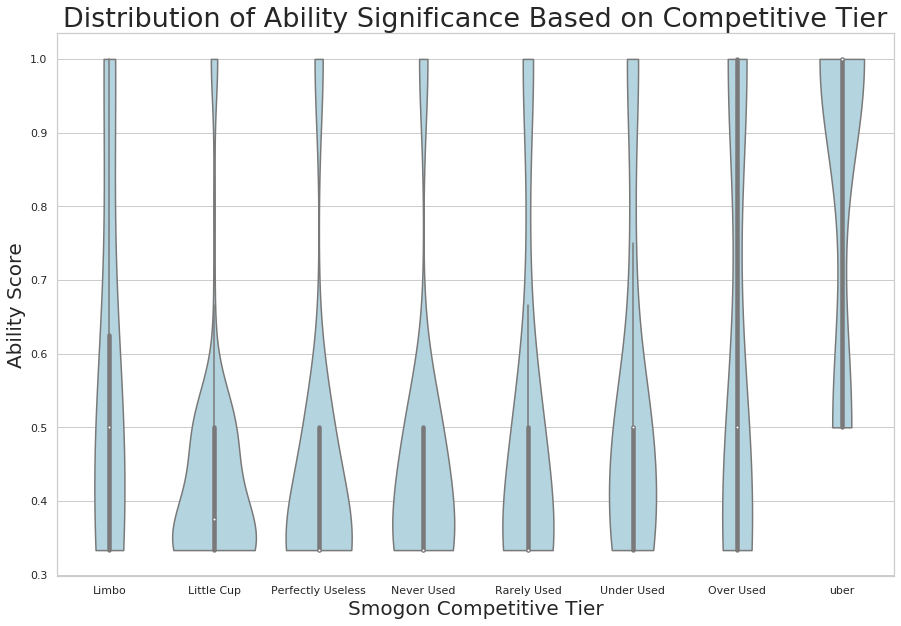

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def form_delete_list(form):
    lst = []
    for form in smog_forms:
        if form != form:
            lst.append(form)
            lst.append(form + '_ratio')
    return lst

final_df = pd.DataFrame(columns = ['form','abil_score'])
for form in smog_forms:
    df_form = df_abils.copy()
    to_delete = form_delete_list(form)
    df_form = df_form.drop(columns = to_delete)
    df_form = df_form[df_form[form] > 0]
    abil_score = df_form[(form+'_ratio')].copy()
    form_list = [form for i in range(0,len(abil_score))]
    temp_df = pd.DataFrame(list(zip(form_list, abil_score)), 
               columns =['form', 'abil_score'])
    final_df = final_df.append(temp_df)

fig, ax = plt.subplots(1,1, figsize = [15,10], sharey = True, sharex = True)
sns.set(style='whitegrid')
ax = sns.violinplot(x='form', y = 'abil_score', data = final_df, cut = 0, scale = "area",
                 showmeans = True, order = smog_forms, color = 'lightblue')
ax.set_xlabel('Smogon Competitive Tier', fontsize = 20)
ax.set_ylabel('Ability Score', fontsize = 20)
ax.set_title('Distribution of Ability Significance Based on Competitive Tier', fontsize = 27)

smog_labels = ['Limbo', 'Little Cup', 'Perfectly Useless', 'Never Used', 'Rarely Used', 'Under Used', 'Over Used', 'uber']

locs, labels = plt.xticks()
plt.xticks(locs, smog_labels)
fig.show()

<bound method Figure.show of <Figure size 1080x720 with 1 Axes>>

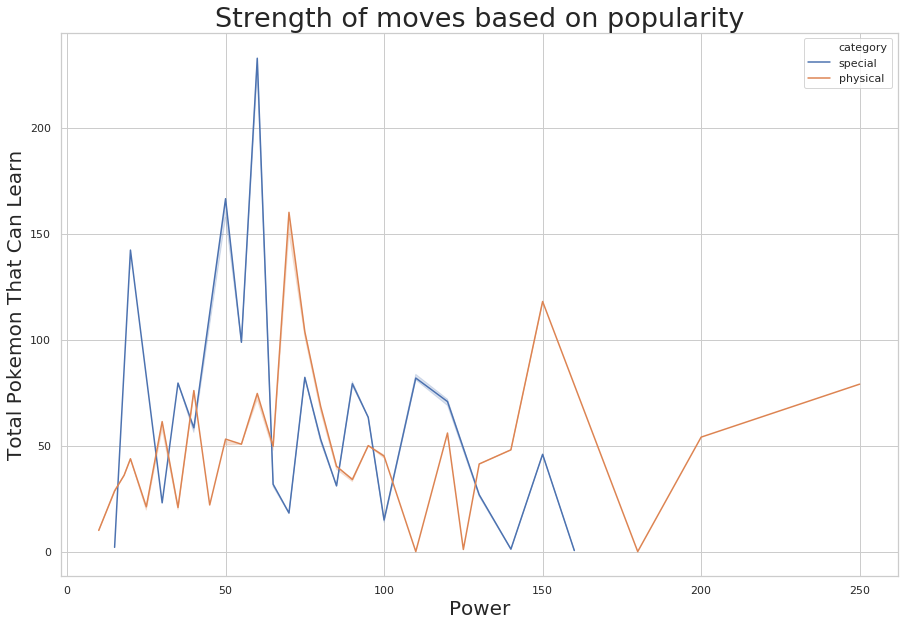

In [42]:
df_moves_cats = df_moves.copy()
df_moves_cats = df_moves_cats.dropna(axis='rows')
fig, ax = plt.subplots(1,1, figsize = [15,10], sharey = True, sharex = True)
sns.set(style='whitegrid')
ax = sns.lineplot(x='power', y = 'total_ct', data = df_moves_cats, hue = 'category', ci = 4)
ax.set_title('Strength of moves based on popularity', fontsize = 27)
ax.set_xlabel('Power', fontsize = 20)
ax.set_ylabel('Total Pokemon That Can Learn', fontsize = 20)
fig.show

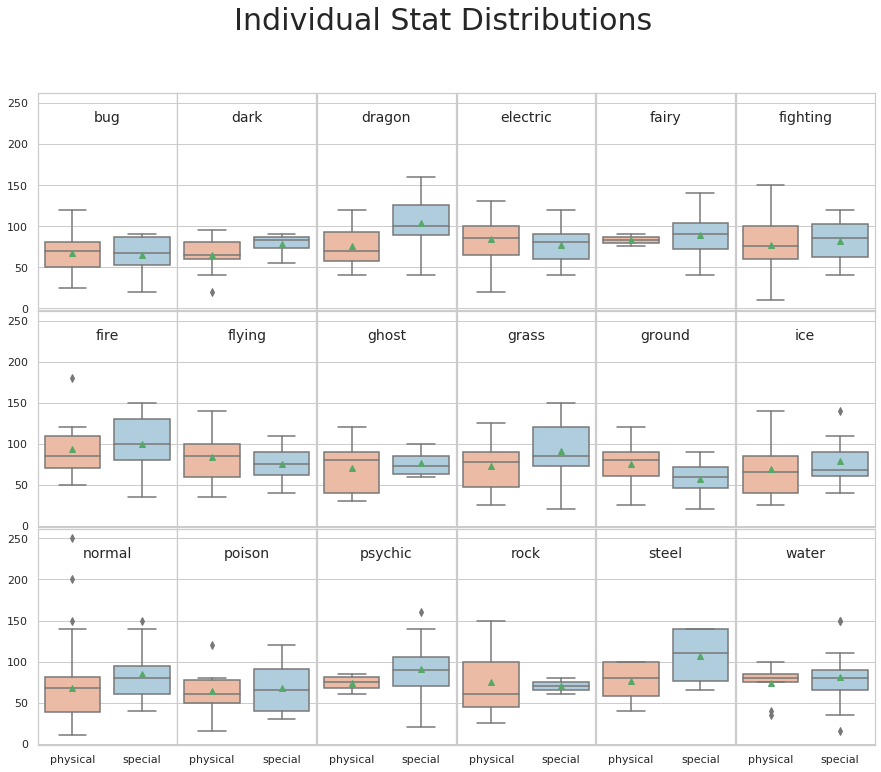

In [43]:
fig, axs = plt.subplots(3,6, figsize = [15,12], sharey = True, sharex = True,
                        gridspec_kw = {'hspace':0.005, 'wspace':0.005})
sns.set(style='whitegrid')
type_colors = ['yellowgreen','dimgray','slateblue','gold','lightpink','lightcoral','orange',
              'lightsteelblue','thistle','olivedrab','burlywood','powderblue','brown',
              'darkorchid','hotpink','peru','silver','lightskyblue']

for i in range(0,len(pokemon_types)):
    pltrow = i//6
    pltcol = i%6
    temp = df_moves_cats[df_moves_cats.type == pokemon_types[i]]
    sns.boxplot(x='category', y = 'power', data = temp, order = ['physical','special'], 
                palette = 'RdBu', showmeans = True, ax = axs[pltrow,pltcol])
    axs[pltrow,pltcol].set_title(pokemon_types[i], x=0.5, y=0.84, fontsize = 14)
    axs[pltrow,pltcol].set_xlabel('')
    axs[pltrow,pltcol].set_ylabel('')
    ax.set_title('Strength of moves based on popularity', fontsize = 27)
    
ax.set_xlabel('Power', fontsize = 20)
ax.set_ylabel('Total Pokemon That Can Learn', fontsize = 20)

fig.suptitle('Move Power Distributions by Type and Category', fontsize = 30)
fig.show()

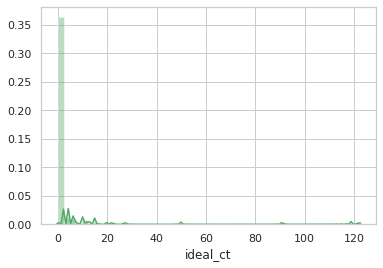

In [44]:
df_items_dist = df_items.copy()

sns.distplot(df_items_dist['ideal_ct'], color="g", kde_kws={"shade": True})


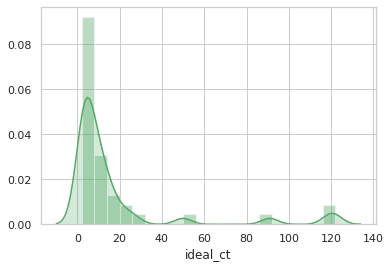

In [45]:
df_items_dist = df_items_dist[df_items_dist['ideal_ct'] >= 2]
sns.distplot(df_items_dist['ideal_ct'], color="g", kde_kws={"shade": True})


In [47]:
print("These items have less than 40 users:")
print(df_items_dist[df_items_dist['ideal_ct'] < 40].head(4))
print("These items have over 40 users:")
print(df_items_dist[df_items_dist['ideal_ct'] > 40])

These items have less than 40 users:
            name                                             effect   mega  \
20  assault-vest  raises-special-defense-but-prevents-the-use-of...  False   
42  black-sludge  a-held-item-that-gradually-restores-the-hp-of-...  False   
57    buginium-z  allows-the-use-of-savage-spin-out,-the-bug-typ...  False   
78   choice-band      raises-attack,-but-only-one-move-can-be-used.  False   

    z_move  ideal_ct  
20   False        10  
42   False        10  
57    True         4  
78   False        20  
These items have over 40 users:
             name                                             effect   mega  \
79   choice-scarf       raises-speed,-but-only-one-move-can-be-used.  False   
147      eviolite  a-mysterious-evolutionary-lump.-when-held,-it-...  False   
284     leftovers  an-item-to-be-held-by-a-pokémon.-the-holder's-...  False   
289      life-orb  increases-the-power-of-moves,-but-loses-hp-eac...  False   

     z_move  ideal_ct  
79   

In [52]:
df_best_items = df_items_dist.copy()
df_best_items = df_best_items[df_best_items['z_move'] == False]
df_best_items.sort_values(by='ideal_ct', ascending = False)

,name,effect,mega,z_move,ideal_ct
147,eviolite,"a-mysterious-evolutionary-lump.-when-held,-it-...",False,False,122
289,life-orb,"increases-the-power-of-moves,-but-loses-hp-eac...",False,False,119
284,leftovers,an-item-to-be-held-by-a-pokémon.-the-holder's-...,False,False,91
79,choice-scarf,"raises-speed,-but-only-one-move-can-be-used.",False,False,50
80,choice-specs,"raises-special-attack,-but-only-one-move-can-b...",False,False,27
178,focus-sash,an-item-to-be-held-by-a-pokémon.-if-it-has-ful...,False,False,22
78,choice-band,"raises-attack,-but-only-one-move-can-be-used.",False,False,20
479,rocky-helmet,"if-the-holder-of-this-item-takes-damage,-the-a...",False,False,15
42,black-sludge,a-held-item-that-gradually-restores-the-hp-of-...,False,False,10
20,assault-vest,raises-special-defense-but-prevents-the-use-of...,False,False,10


In [53]:
df_comp_natures = df_natures.copy()
df_comp_natures = df_comp_natures[df_comp_natures['ideal_ct']!= 0]
df_comp_natures

,increased_stat,decreased_stat,nature,ideal_ct
1,attack,defense,lonely,3
2,attack,speed,brave,9
3,attack,sp.-attack,adamant,123
4,attack,sp.-defense,naughty,5
5,defense,attack,bold,60
7,defense,speed,relaxed,13
8,defense,sp.-attack,impish,33
10,speed,attack,timid,149
11,speed,defense,hasty,14
12,NaN,NaN,serious,1


In [54]:
def find_serious(l):
    return 'serious' in l
for idx, row in df_master.iterrows():
    try:
        if find_serious(row['ideal_nature']):
            print(row['name'])
    except:
        ;

venipede


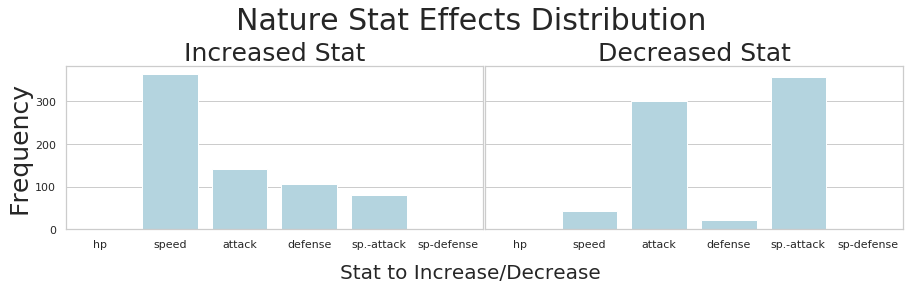

In [105]:
df_comp_natures = df_comp_natures.dropna()
df_comp_natures['inc_sum'] = df_comp_natures.groupby('increased_stat')['ideal_ct'].transform('sum')
df_comp_natures['dec_sum'] = df_comp_natures.groupby('decreased_stat')['ideal_ct'].transform('sum')
fig, axs = plt.subplots(1,2, figsize = [15,3], sharey = True, sharex = True,
                        gridspec_kw = {'hspace':0.5, 'wspace':0.005})

sns.barplot(x = 'increased_stat', y = 'inc_sum', data = df_comp_natures, ax = axs[0],
           order = ['hp','speed','attack','defense','sp.-attack','sp-defense'], color = 'lightblue')
sns.barplot(x = 'decreased_stat', y = 'dec_sum', data = df_comp_natures, ax = axs[1],
           order = ['hp','speed','attack','defense','sp.-attack','sp-defense'], color = 'lightblue')
axs[0].set_xlabel('')
axs[0].set_title('Increased Stat', fontsize = 25)
axs[0].set_ylabel('Frequency', fontsize = 25)
axs[1].set_xlabel('')
axs[1].set_title('Decreased Stat', fontsize = 25)
axs[1].set_ylabel('')

fig.text(0.5, -0.1, 'Stat to Increase/Decrease', ha='center', fontsize = 20)
fig.text(0.5, 1.05, 'Nature Stat Effects Distribution', ha='center', fontsize = 30)

fig.show()

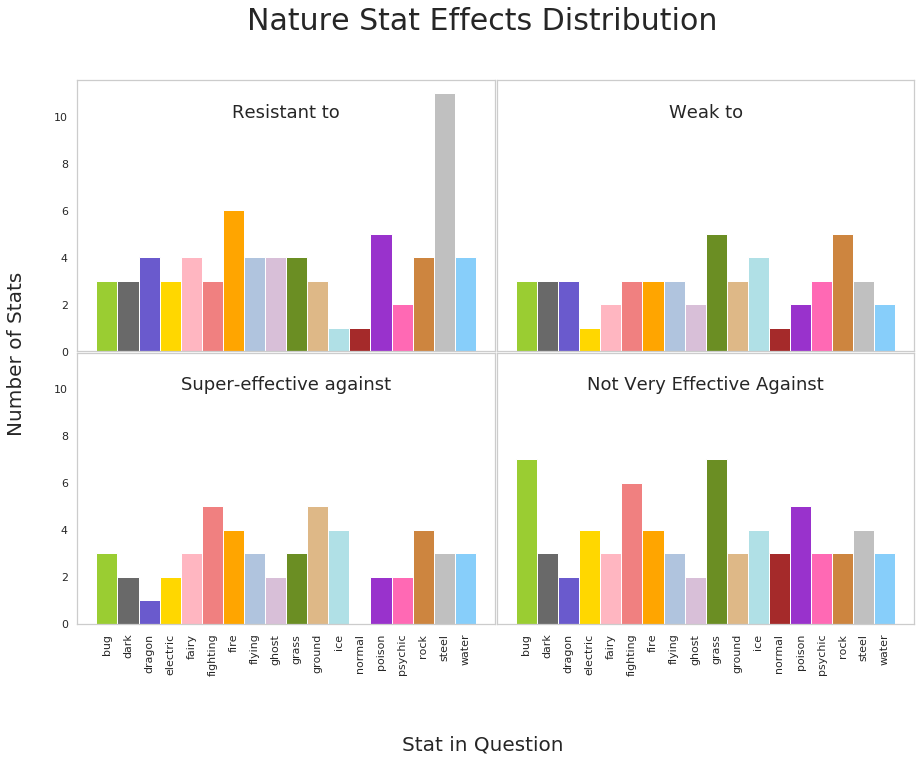

In [111]:
def weak_or_resist(lst, flag):
    count = 0;
    for e in lst:
        if flag and e < 1.0:
            count += 1
        if not flag and e > 1.0:
            count += 1
    return count

df_types['resist'] = 0.0
df_types['weak'] = 0.0
df_types['supereffective'] = 0.0
df_types['notveryeffective'] = 0.0
for idx, row in df_types.iterrows():
    s = row['attacking_type']
    df_types.at[idx, 'resist'] = weak_or_resist(df_types[s], True)
    df_types.at[idx, 'weak'] = weak_or_resist(df_types[s], False)
    supereffective = 0
    notveryeffective = 0
    for t in pokemon_types:
        if row[t] > 1:
            supereffective += 1
        if row[t] < 1:
            notveryeffective += 1
    df_types.at[idx, 'supereffective'] = supereffective
    df_types.at[idx, 'notveryeffective'] = notveryeffective

type_colors = ['yellowgreen','dimgray','slateblue','gold','lightpink','lightcoral','orange',
              'lightsteelblue','thistle','olivedrab','burlywood','powderblue','brown',
              'darkorchid','hotpink','peru','silver','lightskyblue']
fig, axs = plt.subplots(2,2, figsize = [15,10], sharey = True, sharex = True,
                        gridspec_kw = {'hspace':0.005, 'wspace':0.005})

graphl = ['resist','weak','supereffective','notveryeffective']
titlel = ['Resistant to', 'Weak to','Super-effective against', 'Not Very Effective Against']
for i in range(0,4):
    pltrow = i//2
    pltcol = i%2
    axs[pltrow,pltcol].set_title(titlel[i], x=0.5, y=0.84, fontsize = 18)
    axs[pltrow,pltcol].bar(pokemon_types, df_types[graphl[i]], color = type_colors, width = 1.0)
    axs[pltrow,pltcol].set_xticklabels(labels = pokemon_types, rotation='vertical')
    axs[pltrow,pltcol].grid(False)
fig.text(0.5, -0.05, 'Stat in Question', ha='center', fontsize = 20)
fig.text(0.5, .95, 'Nature Stat Effects Distribution', ha='center', fontsize = 30)
fig.text(0.06, 0.5, 'Number of Stats', va='center', rotation = 'vertical', fontsize = 20)
fig.show()

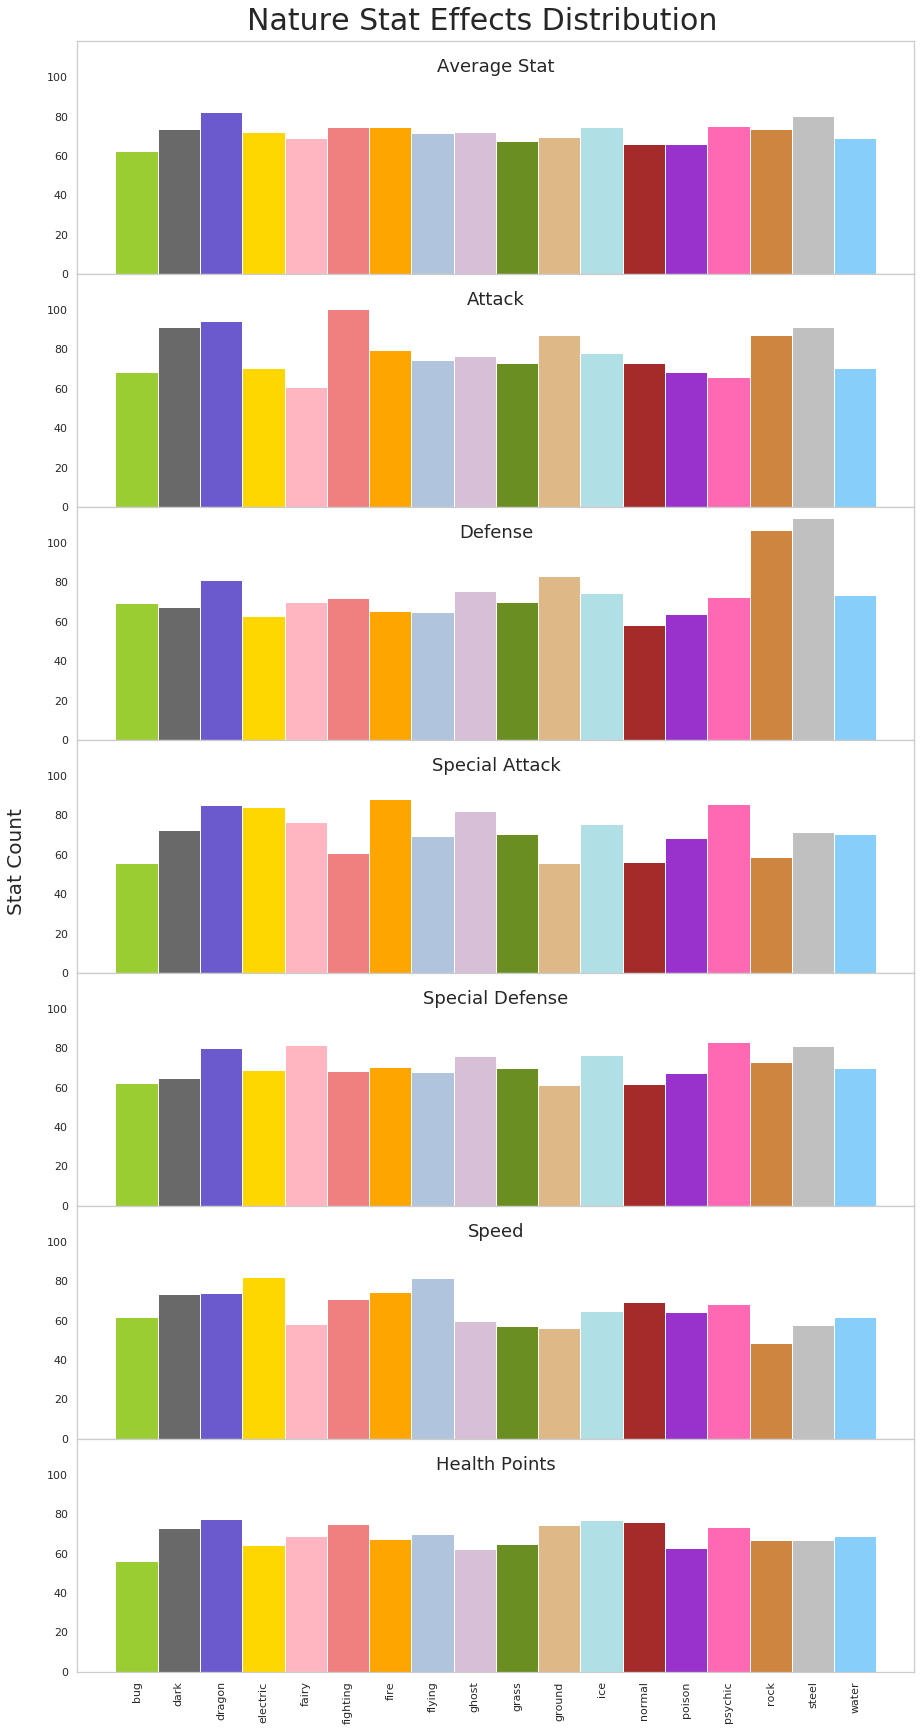

In [119]:
fig, axs = plt.subplots(7,1, figsize = [15,30], sharey = True, sharex = True,
                        gridspec_kw = {'hspace':0.00, 'wspace':0.00})
stats = ['atk','dfn','spa','spd','spe','hp']
stat_labels = ['Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed', 'Health Points']
type_colors = ['yellowgreen','dimgray','slateblue','gold','lightpink','lightcoral','orange',
              'lightsteelblue','thistle','olivedrab','burlywood','powderblue','brown',
              'darkorchid','hotpink','peru','silver','lightskyblue']
for i in range(0,6):
    
    stat_lst = []
    for cur_type in pokemon_types:
        no = df_master.loc[df_master['is_'+cur_type] == True][stats[i]].mean()
        stat_lst.append(no)
        
    axs[i+1].bar(pokemon_types, stat_lst, color = type_colors, width = 1.0)
    axs[i+1].set_title(stat_labels[i], x=0.5, y=0.84, fontsize = 18)
    axs[i+1].set_xticklabels(labels = pokemon_types, rotation='vertical')
    axs[i+1].grid(False)

stat_lst = []
for cur_type in pokemon_types:
    no = df_master.loc[df_master['is_'+cur_type] == True]['total_stats'].mean()
    stat_lst.append(no/6)

axs[0].bar(pokemon_types, stat_lst, color = type_colors, width = 1.0)
axs[0].set_title('Average Stat',  x=0.5, y=0.84, fontsize = 18)
axs[0].grid(False)


fig.text(0.5, .885, 'Nature Stat Effects Distribution', ha='center', fontsize = 30)
fig.text(0.06, 0.5, 'Stat Count', va='center', rotation = 'vertical', fontsize = 20)
fig.show()

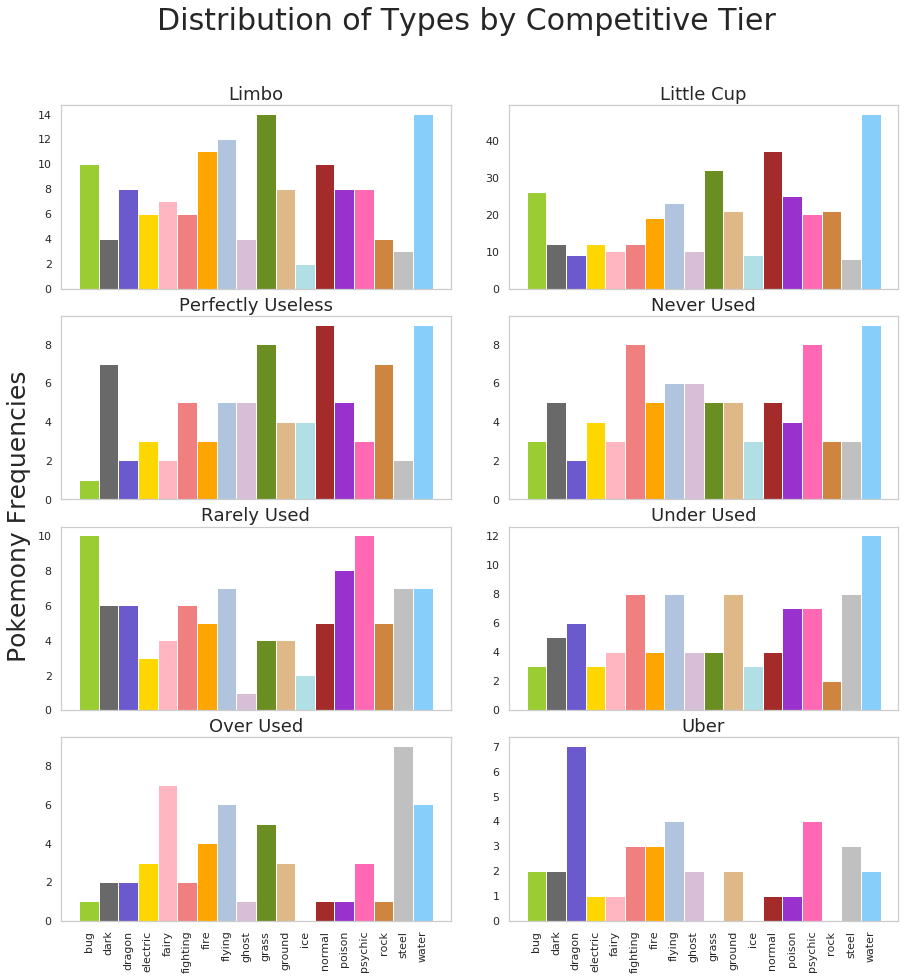

In [156]:
smog_forms = ['limbo', 'lc', 'pu', 'nu', 'ru', 'uu', 'ou', 'uber']
smog_labels = ['Limbo', 'Little Cup', 'Perfectly Useless', 'Never Used', 'Rarely Used', 'Under Used', 'Over Used', 'Uber']

fig, axs = plt.subplots(4,2, figsize = [15,15], sharex = True,
                        gridspec_kw = {'hspace':0.15, 'wspace':0.15})

for i in range(0,8):
    i = 7-i
    pltrow = i//2
    pltcol = i%2
    form = smog_forms[i]
    form_type_count = []
    for cur_type in pokemon_types:
        no = df_types.loc[df_types['attacking_type'] == cur_type]
        no = int(no[form])
        form_type_count.append(no)
    axs[pltrow,pltcol].set_title(smog_labels[i], x=0.5, y=1, fontsize = 18)
    axs[pltrow,pltcol].bar(pokemon_types, form_type_count, color = type_colors, width = 1.0)
    axs[pltrow,pltcol].set_xticklabels(labels = pokemon_types, rotation='vertical')
    axs[pltrow,pltcol].grid(False)
    
fig.text(0.5, .95, 'Distribution of Types by Competitive Tier', ha='center', fontsize = 30)
fig.text(0.075, 0.5, 'Pokemony Frequencies', va='center', rotation = 'vertical', fontsize = 25)

plt.show()

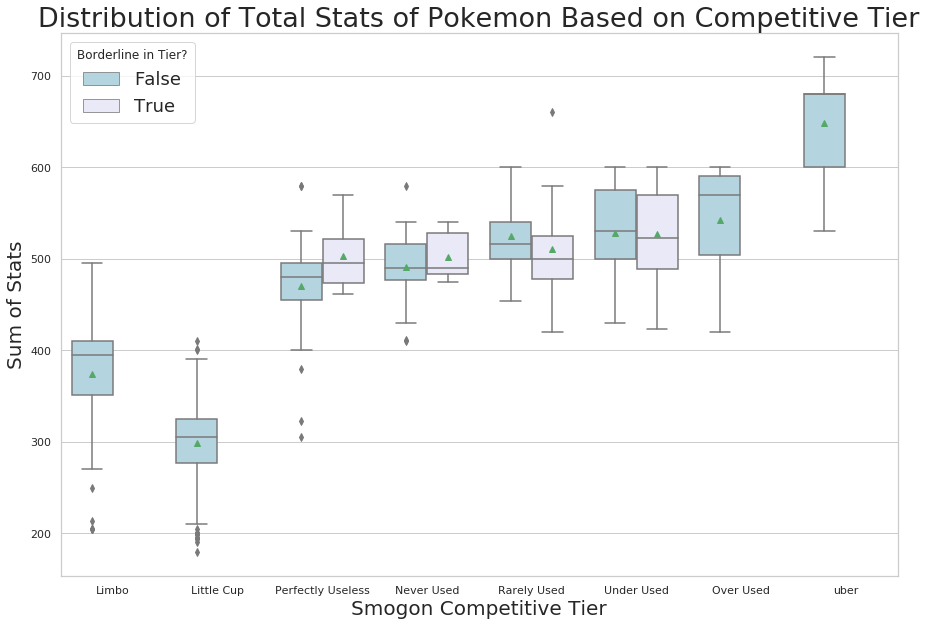

In [124]:
colors = {False:'lightblue', True:'lavender'}
fig, ax = plt.subplots(1,1, figsize = [15,10], sharey = True, sharex = True)
sns.set(style='whitegrid')
ax = sns.boxplot(x='tier', y = 'total_stats', data = df_master,
                 showmeans = True, order = smog_forms, hue = 'is_BL', palette = colors)
ax.set_xlabel('Smogon Competitive Tier', fontsize = 20)
ax.set_ylabel('Sum of Stats', fontsize = 20)

ax.legend(title = 'Borderline in Tier?', loc = 'upper left', prop={'size': 18})
ax.set_title('Distribution of Total Stats of Pokemon Based on Competitive Tier', fontsize = 27)


locs, labels = plt.xticks()
plt.xticks(locs, smog_labels)
plt.show()

Based on the plot, we can see that total stats increase as we go up the competitive tiers. The LC tier is so low, which supports our earlier mini-plot showing that fully evolved Pokemon or ones that only have one evolution generally have better stats. 

Something interesting to note is the gap between the average stats of the tiers is fairly low, with the exceptions of Ubers and the Little Cup. The Uber tier is massively far apart from the other tiers. However, the other tiers are fairly similar in stat distribution. the borderline stats of RU and UU tiers are actually lower on average than those in the actual tier itself. All this together tells us that the stat count of Pokemon are fairly important, but that there are other external factors in determining the strength of a Pokemon!

Let's take a deeper look into the individual stats of Pokemon and their distributions among the different competitive tiers.

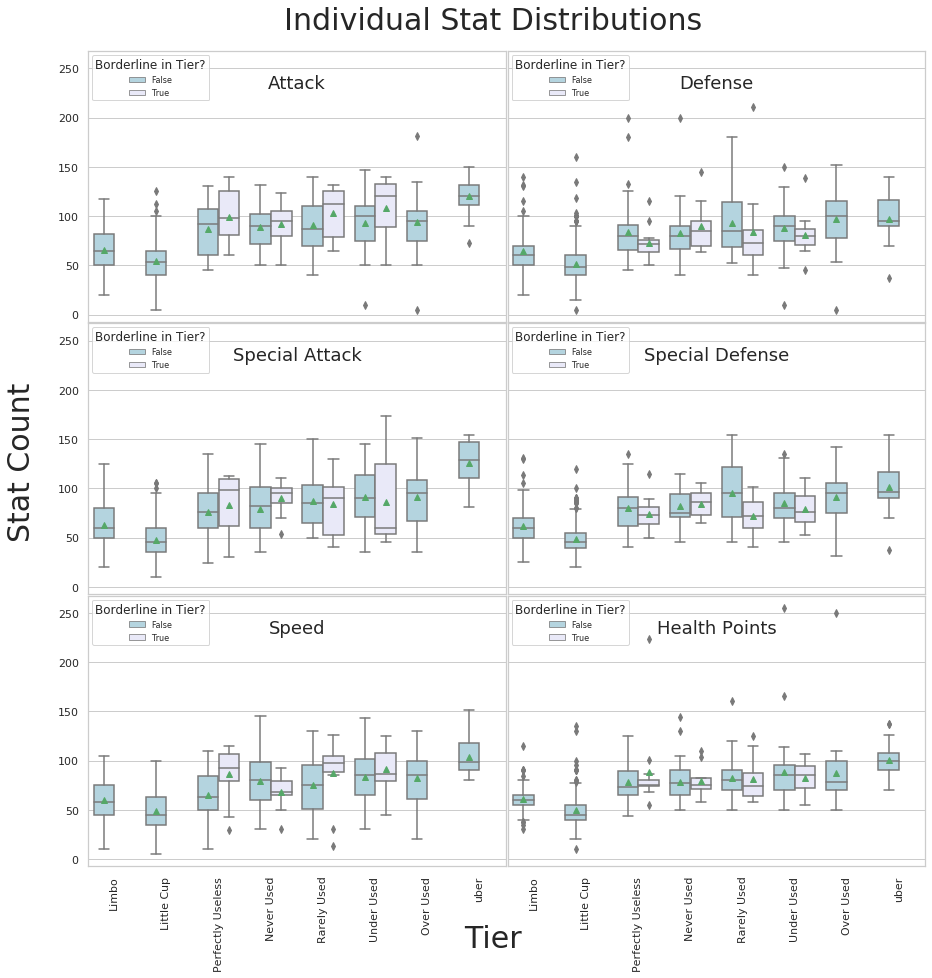

In [129]:
fig, axs = plt.subplots(3,2, figsize = [15,15], sharey = True, sharex = True,
                        gridspec_kw = {'hspace':0.005, 'wspace':0.005})
sns.set(style='whitegrid')

stats = ['atk','dfn','spa','spd','spe','hp']
stat_labels = ['Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed', 'Health Points']
for i in range(0,6):
    pltrow = i//2
    pltcol = i%2
    axs[pltrow,pltcol].set_title(stat_labels[i], x=0.5, y=0.84, fontsize = 18)
    sns.boxplot(x='tier', y = stats[i], data = df_master, hue = 'is_BL', order = smog_forms,  
                palette = colors, showmeans = True, ax = axs[pltrow,pltcol])
    
    axs[pltrow,pltcol].set_xlabel('')
    axs[pltrow,pltcol].set_ylabel('')
    axs[pltrow,pltcol].legend(title = 'Borderline in Tier?', loc = 'upper left', prop={'size': 8})
    axs[pltrow,pltcol].set_xticklabels(labels = smog_labels, rotation ='vertical')

fig.text(0.5, .90, 'Individual Stat Distributions', ha='center', fontsize = 30)
fig.text(0.05, .5, 'Stat Count', va='center', rotation = 'vertical', fontsize = 30)
fig.text(0.5, .05, 'Tier', ha='center', fontsize = 30)

fig.show()

In [ ]:
https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

## Classification

In [164]:
poke_learn = df_master.copy()
poke_learn.columns

Index(['dex_id', 'name', 'spe', 'spd', 'spa', 'dfn', 'atk', 'hp', 'type_1',
       'type_2', 'move_list', 'gen', 'smogon_format', 'is_final_evo',
       'abilities', 'moveset', 'ideal_ability', 'ideal_item', 'ideal_nature',
       'total_stats', 'is_BL', 'tier', 'dam_moves', 'cover_bug', 'cover_dark',
       'cover_dragon', 'cover_electric', 'cover_fairy', 'cover_fighting',
       'cover_fire', 'cover_flying', 'cover_ghost', 'cover_grass',
       'cover_ground', 'cover_ice', 'cover_normal', 'cover_poison',
       'cover_psychic', 'cover_rock', 'cover_steel', 'cover_water',
       'cover_total', 'types', 'is_bug', 'is_dark', 'is_dragon', 'is_electric',
       'is_fairy', 'is_fighting', 'is_fire', 'is_flying', 'is_ghost',
       'is_grass', 'is_ground', 'is_ice', 'is_normal', 'is_poison',
       'is_psychic', 'is_rock', 'is_steel', 'is_water', 'move_count',
       'special_move_count', 'physical_move_count', 'status_move_count',
       'special_moveset', 'physical_moveset', 'status_moves

In [165]:
poke_learn = poke_learn.drop(columns = ['dex_id','name','type_1','type_2','move_list','abilities','moveset','ideal_item',
                                        'ideal_ability','ideal_nature','is_BL','dam_moves', 'types', 'status_move_count',
                                        'special_moveset', 'physical_moveset', 'status_moveset', 'smogon_format'])

poke_learn.columns


Index(['spe', 'spd', 'spa', 'dfn', 'atk', 'hp', 'gen', 'is_final_evo',
       'total_stats', 'tier', 'cover_bug', 'cover_dark', 'cover_dragon',
       'cover_electric', 'cover_fairy', 'cover_fighting', 'cover_fire',
       'cover_flying', 'cover_ghost', 'cover_grass', 'cover_ground',
       'cover_ice', 'cover_normal', 'cover_poison', 'cover_psychic',
       'cover_rock', 'cover_steel', 'cover_water', 'cover_total', 'is_bug',
       'is_dark', 'is_dragon', 'is_electric', 'is_fairy', 'is_fighting',
       'is_fire', 'is_flying', 'is_ghost', 'is_grass', 'is_ground', 'is_ice',
       'is_normal', 'is_poison', 'is_psychic', 'is_rock', 'is_steel',
       'is_water', 'move_count', 'special_move_count', 'physical_move_count'],
      dtype='object')

In [182]:
from sklearn.preprocessing import LabelEncoder
le_tiers = LabelEncoder()
def limboify_form(s):
    if s in smog_forms:
        return s
    return 'limbo'

poke_learn['tier'] = poke_learn['tier'].map(lambda l: limboify_form(l))
poke_inputs = poke_learn.drop('tier', axis = 'columns')
poke_targets = le_tiers.fit_transform(poke_learn['tier'])


In [183]:
def bool_to_int(e):
    if type(e) == bool:
        if e:
            return 1
        return 0
    return e

poke_inputs = poke_inputs.applymap(lambda e: bool_to_int(e))

In [185]:

len(poke_targets) == len(poke_inputs)

True

In [298]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy')

In [305]:
forest_model.fit(poke_inputs, poke_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [300]:
tree_model.score(poke_inputs, poke_targets)

1.0

In [191]:
pip install pydotplus

     |████████████████████████████████| 286kB 5.8MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp37-none-any.whl size=24568 sha256=5a1b8af934092ab256d68f437b34c456b34c58cd99041829b8039097280f1e83
  Stored in directory: /home/jovyan/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [301]:
import pydotplus
from sklearn.datasets import load_iris
from sklearn import tree
import collections


In [303]:
# Visualize data
dot_data = tree.export_graphviz(tree_model,
                                feature_names=poke_inputs.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('img/overfit.png')

True

![urg](overfit.png)

In [307]:
# Visualize data
dot_data = tree.export_graphviz(forest_model.estimators_[0],
                                feature_names=poke_inputs.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('img/forest_overfit.png')

True

In [243]:
from sklearn.model_selection import train_test_split
input_train, input_test, target_train, target_test = train_test_split(poke_inputs, poke_targets, test_size=0.1,
                                                                     random_state = 0) 

In [284]:
tree_model.fit(input_train, target_train)
tree_model.score(input_test, target_test)

0.5189873417721519

In [296]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(criterion = 'entropy', random_state = 0)
forest_model.fit(input_train, target_train)
forest_model.score(input_test, target_test)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6582278481012658

In [286]:
from sklearn.neighbors import KNeighborsClassifier
neigh_model = KNeighborsClassifier(n_neighbors=2)
neigh_model.fit(input_train, target_train)
neigh_model.score(input_test, target_test)

0.7341772151898734

In [287]:
from sklearn.svm import SVC
svm_model = SVC(gamma='scale', degree = 7, kernel = 'poly')
svm_model.fit(input_train, target_train)
svm_model.score(input_test, target_test)

0.7088607594936709

In [297]:
from sklearn.model_selection import cross_val_score
tree_model.fit(poke_inputs, poke_targets)
forest_model.fit(poke_inputs, poke_targets)
neigh_model.fit(poke_inputs, poke_targets)
svm_model.fit(poke_inputs, poke_targets)
print(cross_val_score(tree_model, poke_inputs, poke_targets, cv=10).mean())
print(cross_val_score(forest_model, poke_inputs, poke_targets, cv=10).mean())
print(cross_val_score(neigh_model, poke_inputs, poke_targets, cv=10).mean())
print(cross_val_score(svm_model, poke_inputs, poke_targets, cv=10).mean())


0.5268188247819323
0.5880123680834117
0.576401358919418
0.6046432570417697


## Insight

